## Predict Expected generation 
Use moving average, seasonal features, lag features, and cyclic encoding for hour of day. use other statistical model as needed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import plot_importance
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

/Users/anupbh/miniconda3/envs/hackathon/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
def run_prophet(df):
    '''
    Prophet automatically handles seasonality (daily, yearly, etc.) and trends.
    We do not need to include engineered features like lags, rolling averages, or cyclic encodings in the input DataFrame for Prophet.
    '''
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
    prophet_data = df[['Date','Gen']].rename(columns={'Date':'ds','Gen':'y'})
    prophet = Prophet(daily_seasonality=True, yearly_seasonality=True)
    prophet.fit(prophet_data)
    forecast = prophet.predict(prophet_data)

    df['prophet_pred'] = forecast['yhat']  # seasonality + trend baseline
    df['residual'] = df['Gen'] - df['prophet_pred']
    return df


In [3]:
def run_xgboost(df):
    from xgboost import XGBRegressor
    
    res_features = ['Season_1','Season_2','Season_3','Season_4', 'POD_Night','POD_Morning','POD_Afternoon','POD_Evening','is_weekend','P/OP', 'is_vacation']
    X = df[res_features]
    y = df['residual']
    # y = df['Gen']

    # test-train split
    split_index = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:] 
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    reg = XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.05,
        n_estimators=500
    )

    reg.fit(X_train, y_train)
    df.loc[X_test.index, 'xgb_pred'] = reg.predict(X_test)
    df['final_pred'] = df['prophet_pred'] + df['xgb_pred']
    # clip negative predictions to zero
    df['final_pred'] = df['final_pred'].clip(lower=0)

    # find accuracy for XGBoost residual model
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    mae = mean_absolute_error(df.loc[X_test.index, 'Gen'], df.loc[X_test.index, 'final_pred'])
    print(f"MAE: {mae}")
    
    return df, reg


## Predict for next 5 years

In [4]:
def run_prediction_pipeline(df):
    df_prophet = run_prophet(df)
    df_xgb, reg_xgb = run_xgboost(df_prophet)

    # Plot feature importance
    plt.figure(figsize=(8,6))
    plot_importance(reg_xgb, ax=plt.gca())
    plt.title("Feature Importance")
    plt.show()

    # Create future dates (hourly for 5 years)
    # start from 1 january 2026
    future_dates = pd.date_range(
        start=pd.Timestamp('2026-01-01 00:00:00'),
        end=pd.Timestamp('2026-01-01 00:00:00') + pd.DateOffset(years=5),
        freq='h'
    )
    
    future_df = pd.DataFrame({'Date': future_dates})
    future_df['Month'] = future_df['Date'].dt.month
    future_df['Season'] = future_df['Month'].apply(lambda x: (x%12 + 3)//3)
    season_dummies = pd.get_dummies(future_df['Season'], dtype=int, prefix='Season')
    future_df = pd.concat([future_df, season_dummies], axis=1)
    future_df.drop(columns=['Month', 'Season'], inplace=True)  # drop intermediate columns

    # Add required features (example, adjust as needed)
    future_df['HE'] = future_df['Date'].dt.hour
    future_df['Period_of_Day'] = pd.cut(future_df['HE'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
    pod_dummies = pd.get_dummies(future_df['Period_of_Day'], dtype=int, prefix='POD')
    future_df = pd.concat([future_df, pod_dummies], axis=1)
    future_df.drop(columns=['Period_of_Day'], inplace=True)

    # NERC holidays: New Year's Day, Memorial Day, Labor Day, Thanksgiving, and Christmas
    # add vacation indicator
    future_df['is_vacation'] = future_df['Date'].apply(
        lambda x: 1 if (x.month == 1 and x.day == 1) or
                         (x.month == 5 and x.day >= 25 and x.day <= 31 and x.weekday() == 0) or
                         (x.month == 9 and x.day >= 1 and x.day <= 7 and x.weekday() == 0) or
                         (x.month == 11 and x.month == 11 and x.day >= 22 and x.day <= 28 and x.weekday() == 3) or
                         (x.month == 12 and x.day == 25) else 0
    )
    
    # Peak hours 0 = off-peak, 1 = peak
    # Peak (P) hours = Mon-Fri, HE 7-22 excl NERC holidays
    future_df['P/OP'] = future_df.apply(
        lambda row: 1 if (row['Date'].weekday() < 5 and 7 <= row['Date'].hour <= 22 and row['is_vacation'] == 0) else 0,
        axis=1
    )

    future_df['day_of_week'] = future_df['Date'].dt.dayofweek
    future_df['is_weekend'] = future_df['day_of_week'].isin([5,6]).astype(int)
    

    # use Prophet to predict baseline generation
    prophet_data = future_df[['Date']].rename(columns={'Date':'ds'})
    forecast_future = Prophet(daily_seasonality=True, yearly_seasonality=True).fit(
        df[['Date','Gen']].rename(columns={'Date':'ds','Gen':'y'})
    ).predict(prophet_data)
    future_df['prophet_pred'] = forecast_future['yhat']

    # use XGBoost to predict residuals
    res_features = ['Season_1','Season_2','Season_3','Season_4', 'POD_Night','POD_Morning','POD_Afternoon','POD_Evening','is_weekend','P/OP', 'is_vacation']
    X_future = future_df[res_features]
    future_df['xgb_pred'] = reg_xgb.predict(X_future)
    future_df['final_pred'] = future_df['prophet_pred'] + future_df['xgb_pred']
    # clip negative predictions to zero
    future_df['final_pred'] = future_df['final_pred'].clip(lower=0)
    return future_df
    

Expected generation (by month, peak and off-peak periods).

In [5]:
def aggregate_predictions(prediction, data_dir, data_name):
    prediction['Date'] = pd.to_datetime(prediction['Date'])
    prediction['Year'] = prediction['Date'].dt.year
    prediction['Month'] = prediction['Date'].dt.month

    # peak mask: Mon-Fri HE 7-22, exclude vacations if the flag exists
    if 'is_vacation' in prediction.columns:
        peak_mask = (
            (prediction['Date'].dt.weekday < 5) &
            (prediction['Date'].dt.hour >= 7) &
            (prediction['Date'].dt.hour <= 22) &
            (prediction['is_vacation'] == 0)
        )
    else:
        peak_mask = (
            (prediction['Date'].dt.weekday < 5) &
            (prediction['Date'].dt.hour >= 7) &
            (prediction['Date'].dt.hour <= 22)
        )

    # sum final_pred separately for peak and off-peak, then join into two columns
    peak = prediction.loc[peak_mask].groupby(['Year', 'Month'])['final_pred'].sum().rename('Peak')
    off_peak = prediction.loc[~peak_mask].groupby(['Year', 'Month'])['final_pred'].sum().rename('Off-Peak')

    agg_prediction = pd.concat([peak, off_peak], axis=1).fillna(0).reset_index()

    agg_prediction.to_csv(data_dir + f"/{data_name}-Future-Predictions-Aggregated.csv", index=False)
    return agg_prediction

15:50:27 - cmdstanpy - INFO - Chain [1] start processing
15:50:28 - cmdstanpy - INFO - Chain [1] done processing


MAE: 14.647341902951196


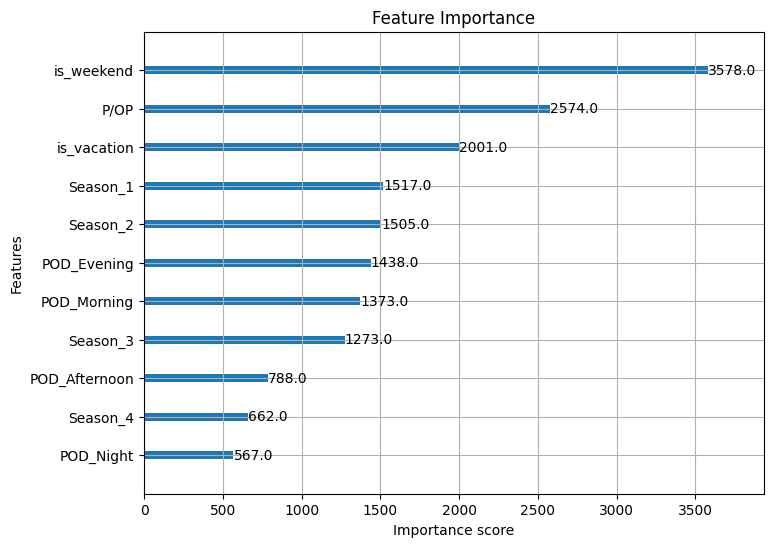

15:50:31 - cmdstanpy - INFO - Chain [1] start processing
15:50:32 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
data_dir = "../data"
historical_df = pd.read_csv(data_dir + "/CAISO-Historical-Data.csv")
prediction = run_prediction_pipeline(historical_df)
prediction.to_csv(data_dir + "/CAISO-Future-Predictions.csv", index=False)

In [7]:
agg_prediction = aggregate_predictions(prediction, data_dir, "CAISO")


Plot the results

In [8]:
def plot_results(df_old, df_new):
    plt.figure(figsize=(14,6))
    plt.plot(df_old['Date'], df_old['Gen'], label='Historical Generation', alpha=0.5)
    plt.plot(df_new['Date'], df_new['final_pred'], label='Predicted Generation', alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('Generation')
    plt.title('Historical vs Predicted Generation')
    plt.legend()
    plt.show()

In [9]:
def plot_results_by_year(old_df, new_df, old_year, new_year):
    """
    Plot historical and predicted generation for a specific year as overlapping line charts with smoothed trendlines.
    X axis shows months only (Jan, Feb, ... Dec).
    """
    from scipy.interpolate import make_interp_spline

    old_df['Date'] = pd.to_datetime(old_df['Date'])
    new_df['Date'] = pd.to_datetime(new_df['Date'])
    old_mask = old_df['Date'].dt.year == old_year
    new_mask = new_df['Date'].dt.year == new_year

    # Aggregate by month
    old_months = old_df.loc[old_mask].groupby(old_df.loc[old_mask, 'Date'].dt.month)['Gen'].mean()
    new_months = new_df.loc[new_mask].groupby(new_df.loc[new_mask, 'Date'].dt.month)['final_pred'].mean()

    months = np.array(range(1, 13))
    months_smooth = np.linspace(1, 12, 100)

    # Spline for smooth trendlines
    old_spline = make_interp_spline(months, old_months, k=3)
    new_spline = make_interp_spline(months, new_months, k=3)

    plt.figure(figsize=(10,6))
    # Line charts
    plt.plot(months, old_months, label=f'Historical Generation {old_year}', color='tab:blue', alpha=0.7)
    plt.plot(months, new_months, label=f'Predicted Generation {new_year}', color='tab:orange', alpha=0.7)
    # Smoothed trendlines
    plt.plot(months_smooth, old_spline(months_smooth), color='tab:blue', linestyle='--', label=f'Smooth Trend {old_year}')
    plt.plot(months_smooth, new_spline(months_smooth), color='tab:orange', linestyle='--', label=f'Smooth Trend {new_year}')

    plt.xlabel('Month')
    plt.ylabel('Generation MW/h')
    plt.title(f'Historical ({old_year}) vs Predicted ({new_year}) Generation (Monthly Average with Trendline)')
    plt.legend()
    plt.xticks(ticks=range(1,13), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    plt.tight_layout()
    # plt.show()
    # save plot
    plt.savefig(f'Generation_Comparison_{old_year}_vs_{new_year}.png')

In [ ]:
# plot for all possible years pair
# historical year: 2022-2024
# predicted year: 2026-2030
for hist_year in range(2022, 2025):
    for pred_year in range(2026, 2031):
        plot_results_by_year(historical_df, prediction, hist_year, pred_year)